# GRABEN

In [1]:
import sys
sys.path.append("../../gempy")
sys.path.append("../../pynoddy")
import copy
import importlib

import numpy as np
import pandas as pn
import math

import gempy as gp
from gempy import Topology as tp
#np.set_printoptions(threshold=10000000)
# import pynoddy
# import pynoddy.history
# import pynoddy.output
# import pynoddy.events
# import pynoddy.experiment

import matplotlib.pyplot as plt
%matplotlib inline

import pymc
import theano

# Data Import

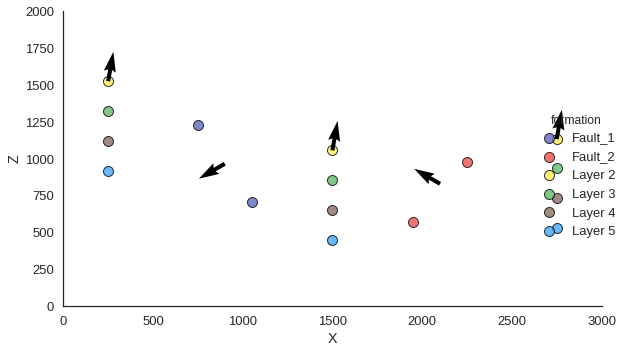

In [2]:
# geo_data = gp.read_pickle("exp1_data.pickle")

# initialize geo_data object
geo_data = gp.create_data([0, 3000, 0, 75, 0, 2000],
                          resolution=[120, 3, 80])

geo_data.import_data_csv("data/exp1_graben_interf.csv", "data/exp1_graben_fol.csv")
geo_data.calculate_gradient()

form = np.delete(geo_data.get_formations(), np.where(geo_data.get_formations()=="Fault_1")[0][0])
gp.set_series(geo_data, {"Fault_1":geo_data.get_formations()[np.where(geo_data.get_formations()=="Fault_1")[0][0]],
                         "Fault_2":geo_data.get_formations()[np.where(geo_data.get_formations()=="Fault_2")[0][0]],
                         "Rest":np.delete(form, np.where(form=="Fault_2"))},
                           order_series = ["Fault_1", "Fault_2", "Rest"], verbose=0, order_formations=['Fault_1', "Fault_2",'Layer 2', 'Layer 3', 'Layer 4', 'Layer 5'])

geo_data.set_formation_number()
geo_data.order_table()

%matplotlib inline
gp.plot_data(geo_data)
plt.xlim(0,3000)
plt.ylim(0,2000)
plt.tight_layout()
#plt.savefig("input_data.pdf")

In [3]:
#geo_data = gp.select_series(geo_data, ["Rest", 'Fault_1'])

In [4]:
# interp_data = gp.InterpolatorInput(geo_data, u_grade=[0,0,3], dtype="float64")  #, verbose=['n_formation'], dtype="float32")
# lith_block, fault_block = gp.compute_model(interp_data)

In [5]:
# fault_block

In [6]:
#interp_data.geo_data_res.n_faults

In [7]:
gp.plot_data_3D(geo_data)

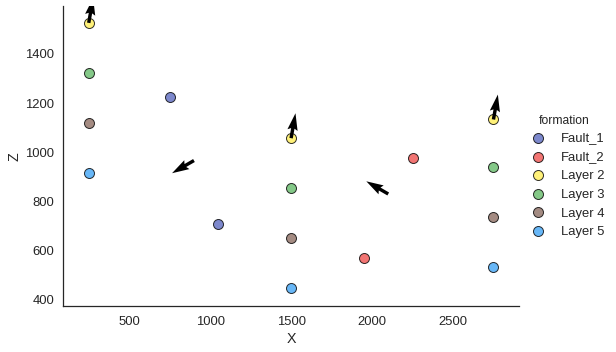

In [8]:
gp.plot_data(geo_data)


In [14]:
interp_data = gp.InterpolatorInput(geo_data, u_grade=[3,3,3], dtype="float64",
                                   verbose=[])


Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64


In [15]:
interp_data.interpolator.tg.n_formation.get_value()

array([1, 2, 3, 4, 5, 6])

In [16]:
lith_block, fault_block = gp.compute_model(interp_data)

Labels & Stuff:

In [12]:
fault_block[0].shape, lith_block.shape

((28800,), (2, 28800))

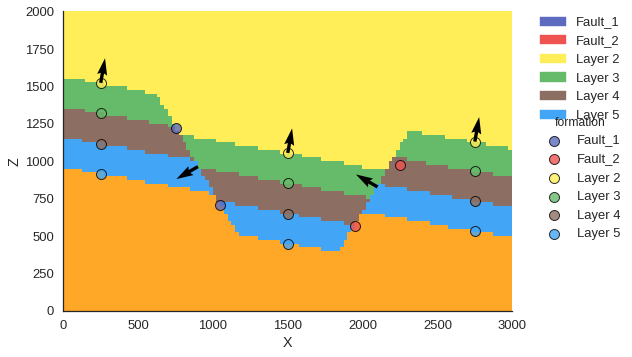

In [12]:
%matplotlib inline
gp.plot_section(geo_data, lith_block[0], 0, plot_data=True)
#plt.savefig("exp1_graben_model_w_input_data.pdf")

In [13]:
ver, sim = gp.get_surfaces(interp_data, lith_block[1], [fault_block[1], fault_block[3]], original_scale=False)
gp.plot_surfaces_3D_real_time(interp_data, ver, sim, alpha=1)

n_formation_fault __str__ = [1]
length_of_C __str__ = 7
length_of_CG __str__ = 3
length_of_CGI __str__ = 1
length_of_U_I __str__ = 3
length_of_faults __str__ = 0
Faults gradients matrix __str__ = []
Faults interfaces matrix __str__ = []
Faults contribution __str__ = [ 0.  0.  0. ...,  0.  0.  0.]
n_formation_fault __str__ = [2]
length_of_C __str__ = 8
length_of_CG __str__ = 3
length_of_CGI __str__ = 1
length_of_U_I __str__ = 3
length_of_faults __str__ = 1
Faults gradients matrix __str__ = [[ 0.  0.  0.]]
Faults interfaces matrix __str__ = [[ 0.0001]]
Faults contribution __str__ = [ 223.23048454  223.23048454  223.23048454 ...,  223.23048454  223.23048454
  223.23048454]
length_of_C __str__ = 22
length_of_CG __str__ = 9
length_of_CGI __str__ = 8
length_of_U_I __str__ = 3
length_of_faults __str__ = 2
Faults gradients matrix __str__ = [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]]
Faults interfaces matrix __str__ = [[  1.00010000e+00   1.00010000e+00   1.00

In [ ]:
%debug

In [ ]:
 interp_data.geo_data_res.interfaces['formation number'][
            interp_data.geo_data_res.interfaces['isFault']].unique()

In [ ]:
np.atleast_2d([a,a])[0]

In [ ]:
group_ids = np.unique(geo_data.interfaces["group_id"])
layer_ids = group_ids[group_ids!="Fault_1"]
layer_ids = group_ids[group_ids!="Fault_2"]
layer_ids_u = [l[:-2] for l in layer_ids]
layer_ids_u = np.unique(layer_ids_u)

# PYMC Implementation

## Priors

Create pymc.Normal distributions (mean 0) as prior parameters for the layer interface positions (modifier):

In [ ]:
geo_data.interfaces

In [ ]:
interp_data.geo_data_res.foliations

In [ ]:
interf_Z_modifier = []
interf_Z_std = 40.

for g_id in ['l2', 'l3', 'l4', 'l5']:
    interf_Z_modifier.append(pymc.Normal(g_id, 0, 1./interf_Z_std**2))
    
fault_1_dip = pymc.Normal("fault_1_dip", 60., 1./5**2)
fault_2_dip = pymc.Normal("fault_2_dip", 60., 1./5**2)
strat_dip = pymc.Normal("strat_dip", 15., 1./5**2)

For the fault we only want to change the dip angle, so we create a PlaneData object:

In [ ]:
# first we remove the initial fault foliation
try:
    i = geo_data.foliations[geo_data.foliations["formation"]=="Fault_1"].index
    geo_data.foliations.drop(i, inplace=True)
    i = geo_data.foliations[geo_data.foliations["formation"]=="Fault_2"].index
    geo_data.foliations.drop(i, inplace=True)
except ValueError:
    pass
# then create it coupled with the interface points
fault_plane_1 = gp.DataManagement.DataPlane(geo_data, "Fault_1", "interf_to_fol")
fault_plane_1.set_fol()
fault_plane_2 = gp.DataManagement.DataPlane(geo_data, "Fault_2", "interf_to_fol")
fault_plane_2.set_fol()

Visualize the distribution:

In [ ]:
# sample from a distribtion
samples = [strat_dip.rand() for i in range(10000)]
# plot histogram
plt.hist(samples, bins=24, normed=True);
plt.xlabel("Fault Dip Angle")
plt.vlines(60, 0, 0.01)
#plt.xlim(40, 80)
plt.ylabel("n");

Reset series, somehow this gets messed up above - fix!

In [ ]:
form = np.delete(geo_data.get_formations(), np.where(geo_data.get_formations()=="Fault_1")[0][0])
gp.set_series(geo_data, {"Fault_1":geo_data.get_formations()[np.where(geo_data.get_formations()=="Fault_1")[0][0]],
                         "Fault_2":geo_data.get_formations()[np.where(geo_data.get_formations()=="Fault_2")[0][0]],
                         "Rest":np.delete(form, np.where(form=="Fault_2"))},
                           order_series = ["Fault_1", "Fault_2", "Rest"], verbose=0, order_formations=['Fault_1', "Fault_2",'Layer 2', 'Layer 3', 'Layer 4', 'Layer 5'])

geo_data.set_formation_number()
geo_data.order_table()

interp_data.geo_data_res.foliations.set_value(0, "group_id", "Fault_1")
interp_data.geo_data_res.foliations.set_value(1, "group_id", "Fault_2")
interp_data.geo_data_res.foliations.set_value(2, "group_id", "l2_a")
interp_data.geo_data_res.foliations.set_value(3, "group_id", "l2_b")
interp_data.geo_data_res.foliations.set_value(4, "group_id", "l2_c")

interp_data_original.geo_data_res.foliations.set_value(0, "group_id", "Fault_1")
interp_data_original.geo_data_res.foliations.set_value(1, "group_id", "Fault_2")
interp_data_original.geo_data_res.foliations.set_value(2, "group_id", "l2_a")
interp_data_original.geo_data_res.foliations.set_value(3, "group_id", "l2_b")
interp_data_original.geo_data_res.foliations.set_value(4, "group_id", "l2_c")

## Deterministic Functions

### Utility Functions

In [ ]:
def rescale(value, rf=interp_data.rescaling_factor):
    return value / rf

def recalc_gradients(folations_dataframe):
    folations_dataframe["G_x"] = np.sin(np.deg2rad(folations_dataframe["dip"].astype('float'))) * \
                             np.sin(np.deg2rad(folations_dataframe["azimuth"].astype('float'))) * \
                             folations_dataframe["polarity"].astype('float')
    folations_dataframe["G_y"] = np.sin(np.deg2rad(folations_dataframe["dip"].astype('float'))) * \
                             np.cos(np.deg2rad(folations_dataframe["azimuth"].astype('float'))) *\
                             folations_dataframe["polarity"].astype('float')
    folations_dataframe["G_z"] = np.cos(np.deg2rad(folations_dataframe["dip"].astype('float'))) *\
                             folations_dataframe["polarity"].astype('float')

Create Plane object for fault plane:

In [ ]:
from gempy import UncertaintyAnalysisPYMC2
importlib.reload(UncertaintyAnalysisPYMC2)
fault_plane1 = UncertaintyAnalysisPYMC2.Plane("Fault_1", interp_data.geo_data_res)
fault_plane2 = UncertaintyAnalysisPYMC2.Plane("Fault_2", interp_data.geo_data_res)

### Input data handling

In [ ]:
layer_ids_u = np.delete(layer_ids_u, np.where(layer_ids_u=="Fault"))

In [ ]:
interp_data.geo_data_res.interfaces

In [ ]:
layer_ids_u

In [ ]:
@pymc.deterministic(trace=True)
def input_data(value = 0,
               interf_Z_modifier = interf_Z_modifier,
               strat_dip = strat_dip,
               fault_1_dip = fault_1_dip,
               fault_2_dip = fault_2_dip,
               fault_plane1 = fault_plane1,
               fault_plane2 = fault_plane2,
               group_ids = group_ids,
               layer_ids = layer_ids,
               layer_ids_u = layer_ids_u,
               interp_data = interp_data,
               interp_data_original = interp_data_original,
               verbose=True):

    # reset data in geo_data_res to geo_data 
    # (this now includes the updated fault plane data)
    interp_data.geo_data_res = copy.deepcopy(interp_data_original.geo_data_res)
    #interp_data_stoch = gp.get_data(interp_data.geo_data_res, numeric=True)
    if verbose is True:
        #print(interp_data_stoch)
        print(interp_data.geo_data_res.interfaces[["X", "Y", "Z"]].astype(float))
        print(interp_data.geo_data_res.foliations[["G_x", "G_y", "G_z", "X", "Y", "Z", "azimuth", "dip", "polarity"]].astype(float))
    
    fault_plane1 = UncertaintyAnalysisPYMC2.Plane("Fault_1", interp_data.geo_data_res)
    fault_plane2 = UncertaintyAnalysisPYMC2.Plane("Fault_2", interp_data.geo_data_res)
    # fault plane
    if verbose == "dip":
        print(interp_data.geo_data_res.foliations["dip"])
    
    fault_plane1.interf_recalc_Z(fault_1_dip)
    fault_plane2.interf_recalc_Z(fault_2_dip)
    
    if verbose == "dip":
        print(interp_data.geo_data_res.foliations["dip"])
    
    # interf dip
    for affix in ["_a", "_b", "_c"]:
        f = interp_data.geo_data_res.foliations["group_id"] == "l2" + affix
        index = interp_data.geo_data_res.foliations[f].index
        interp_data.geo_data_res.foliations.set_value(index, "dip", int(strat_dip))
    recalc_gradients(interp_data.geo_data_res.foliations)
    
    # interf vertical mod
    for i, layer_id in enumerate(layer_ids_u):
        for affix in ["_a", "_b", "_c"]:
            # interface positions
            f = interp_data.geo_data_res.interfaces["group_id"] == layer_id + affix
            index = interp_data.geo_data_res.interfaces[f].index
            # get the z value of the interface
            vals = interp_data.geo_data_res.interfaces.iloc[index]["Z"].astype(float).values
            if verbose is True:
                print("vals of ",layer_id,affix,vals)
                
            # modify it with the according rescaled prior
            vals += rescale(interf_Z_modifier[i])
            if verbose is True:
                print("vals mod:",rescale(interf_Z_modifier[i]))
            # replace value
            interp_data.geo_data_res.interfaces.set_value(index, "Z", vals)
            if verbose is True:
                print("modded val:",interp_data.geo_data_res.interfaces.iloc[index]["Z"])
            
            # foliation positions
            f = interp_data.geo_data_res.foliations["group_id"] == layer_id + affix
            index = interp_data.geo_data_res.foliations[f].index
            # get the z value of the interface
            vals = interp_data.geo_data_res.foliations.iloc[index]["Z"].astype(float).values
            # modify it with the according rescaled prior
            vals += rescale(interf_Z_modifier[i])
            # replace value
            interp_data.geo_data_res.foliations.set_value(index, "Z", vals) 
            
    interp_data.update_interpolator()
    
    if verbose is True:
        print(interp_data.geo_data_res.interfaces[["X", "Y", "Z"]].astype(float))
        print(interp_data.geo_data_res.foliations[["G_x", "G_y", "G_z", "X", "Y", "Z", "azimuth", "dip", "polarity"]].astype("float64"))
    
    return [interp_data.geo_data_res.interfaces[["X", "Y", "Z"]].astype(float), 
            interp_data.geo_data_res.foliations[["G_x", "G_y", "G_z", "X", "Y", "Z", "azimuth", "dip", "polarity"]].astype("float64")]

### GemPy modeling function

In [ ]:
gp.get_kriging_parameters(interp_data)

In [ ]:
%matplotlib inline
# interp_data.update_interpolator(geo_data_res=interp_data.geo_data_res, range_var=0.9)
@pymc.deterministic(trace=False)  # turn on/off storing the model blocks in db
def gempy_model(value=0,
                input_data=input_data,
                verbose=False):
    
    # modify input data values accordingly
    # interp_data.geo_data_res.interfaces[["X", "Y", "Z"]] = input_data[0]
    # interp_data.geo_data_res.foliations[["G_x", "G_y", "G_z", "X", "Y", "Z", "azimuth", "dip", "polarity"]] = input_data[1]
    
    try:
        # try to compute model
        lb, fb = gp.compute_model(interp_data)
        if verbose:
            gp.plot_section(interp_data.geo_data_res, lb[0], 0, plot_data=False)
            
        return lb, fb
    
    except numpy.linalg.linalg.LinAlgError as err:
        # if it fails (e.g. some input data combinations could lead to 
        # a singular matrix and thus break the chain) return an empty model
        # with same dimensions (just zeros)
        if verbose:
            print("Exception occured.")
            
        return np.zeros_like(lith_block), np.zeros_like(fault_block)

### Topology function

In [ ]:
@pymc.deterministic
def gempy_topo(value=0, gm=gempy_model, verbose=False):
    
    G, c, lu, lot1, lot2 = gp.topology_compute(geo_data, gm[0][0], gm[1][0], 
                                               cell_number=0, direction="y")
    
    if verbose:
        gp.plot_section(geo_data, gm[0][0], 0)
        gp.topology_plot(geo_data, G, c)
    return G, c, lu, lot1, lot2

# Likelihood Functions

In [ ]:
sys.path.append("../")
from pynoddy.experiment import pymc2_posterior

importlib.reload(pymc2_posterior)
importlib.reload(pynoddy.history)
pp = pymc2_posterior.Pymc2Posterior("pyn_graben_run4.hdf5")
# pp.topo_analyze()

In [ ]:
pp.set_history("init4.his")
pp.set_experiment()

In [ ]:
pp.topo_analyze()

In [ ]:
pp.topo_count_connection(4,7)/pp.db.getstate()["sampler"]["_iter"] * 100

## Single Adjacency Area Likelihood

In [ ]:
def get_areas_for_edge_for_topo_id(pp_obj, topo_id, n1, n2):
    """Get all area values for edge n1--n2 from a certain topo_id."""
    areas = np.array([])
    for i in np.where(pp.topo_unique_ids == topo_id)[0]:
        try:
            a = pp_obj.topo_graphs[i].adj[n1][n2]["area"]
            areas = np.append(areas, a)
        except KeyError:
            # edge does not exist -> set 0 as adjacency area
            a = 0.
            areas = np.append(areas, a)
            # continue
    return areas

def get_all_possible_edges(topos):
    """Get all occuring edges throughout all graphs in list/array."""
    storage = []
    for graph in topos:
        for edge in graph.edges():
            if edge in storage:
                continue
            else:
                storage.append(edge)
    return storage

def combined_areas_for_all_topo_ids(edge_areas, edge):
    storage = np.array([])
    for i in range(len(edge_areas)):
        storage = np.append(storage, edge_areas[i][edge])
    return storage

In [ ]:
def get_area_for_edge(G, e):
    """Get adjacency area of edge e (a, b) in graph G. 
    Returns 0 if no edge/area exists."""
    try:
        return G.adj[e[0]][e[1]]["area"]
    except KeyError:
        return 0

def get_area_for_edge_all(graphs, e):
    """e = (a, b) edge"""
    areas = np.array([])
    for G in graphs:
        areas = np.append(areas, get_area_for_edge(G, e))
    return areas

In [ ]:
edges = [(4,7), (4,8), (4,9),
         (3,7), (3,8), (3,9),
         (2,7), (2,8), (2,9),
         (7,14), (7,13), (7,12),
         (8,14), (8,13), (8,12),
         (9,14), (9,13), (9,12)]

In [ ]:
from sklearn.neighbors import KernelDensity

In [ ]:
kde_list = []
for e in edges:
    a = get_area_for_edge_all(pp.topo_graphs, e)
    kde_list.append(KernelDensity(kernel="gaussian").fit(a.reshape(-1, 1)))

### fix pymc

In [ ]:
def stochastic_from_data(name, data, lower=-np.inf, upper=np.inf,
                         value=None, observed=False, trace=True, verbose=-1, debug=False):
    """
    Return a Stochastic subclass made from arbitrary data.

    The histogram for the data is fitted with Kernel Density Estimation.

    :Parameters:
      - `data`  : An array with samples (e.g. trace[:])
      - `lower` : Lower bound on possible outcomes
      - `upper` : Upper bound on possible outcomes

    :Example:
       >>> from pymc import stochastic_from_data
       >>> pos = stochastic_from_data('posterior', posterior_samples)
       >>> prior = pos # update the prior with arbitrary distributions

    :Alias:
      Histogram
    """
    pdf = scipy.stats.kde.gaussian_kde(data)  # automatic bandwidth selection

    # account for tail contribution
    lower_tail = upper_tail = 0.
    if lower > -np.inf:
        lower_tail = pdf.integrate_box(-np.inf, lower)
    if upper < np.inf:
        upper_tail = pdf.integrate_box(upper, np.inf)
    factor = 1. / (1. - (lower_tail + upper_tail))

    def logp(value):
        prob = factor * pdf(value)
        if value < lower or value > upper:
            return -np.inf
        elif prob <= 0.:
            return -np.inf
        else:
            return np.log(prob)

    def random():
        res = pdf.resample(1)[0][0]
        while res < lower or res > upper:
            res = pdf.resample(1)[0][0]
        return res

    if value is None:
        value = random()

    return pymc.Stochastic(logp=logp,
                      doc='Non-parametric density with Gaussian Kernels.',
                      name=name,
                      parents={},
                      random=random,
                      trace=trace,
                      value=value,
                      dtype=float,
                      observed=observed,
                      verbose=verbose)


# Alias following Stochastics naming convention
Histogram = stochastic_from_data

create likelihood functions:

In [ ]:
like_list = []
for e in edges:
    a = get_area_for_edge_all(pp.topo_graphs, e)
    #like_list.append(stochastic_from_data("like_"+str(e[0])+"_"+str(e[1]), a, lower=0, value=get_area_for_edge(gempy_topo_extract.value, e)))
    like_list.append(pymc.Normal("like_"+str(e[0])+"_"+str(e[1]), mu=get_area_for_edge(gempy_topo_extract.value, e), tau=1./np.std(a)**2, observed=True, value=a))

In [ ]:
like_list

In [ ]:
len(edges)

In [ ]:
@pymc.stochastic
def like_area_edge_0(value=0, i=0, kde_list=kde_list, edges=edges, gempy_topo=gempy_topo):
    return kde_list[i].score(get_area_for_edge(gempy_topo[0], edges[i]))

@pymc.stochastic
def like_area_edge_1(value=0, i=1, kde_list=kde_list, edges=edges, gempy_topo=gempy_topo):
    return kde_list[i].score(get_area_for_edge(gempy_topo[0], edges[i]))

@pymc.stochastic
def like_area_edge_2(value=0, i=2, kde_list=kde_list, edges=edges, gempy_topo=gempy_topo):
    return kde_list[i].score(get_area_for_edge(gempy_topo[0], edges[i]))

@pymc.stochastic
def like_area_edge_3(value=0, i=3, kde_list=kde_list, edges=edges, gempy_topo=gempy_topo):
    return kde_list[i].score(get_area_for_edge(gempy_topo[0], edges[i]))

@pymc.stochastic
def like_area_edge_4(value=0, i=4, kde_list=kde_list, edges=edges, gempy_topo=gempy_topo):
    return kde_list[i].score(get_area_for_edge(gempy_topo[0], edges[i]))

@pymc.stochastic
def like_area_edge_5(value=0, i=5, kde_list=kde_list, edges=edges, gempy_topo=gempy_topo):
    return kde_list[i].score(get_area_for_edge(gempy_topo[0], edges[i]))

@pymc.stochastic
def like_area_edge_6(value=0, i=6, kde_list=kde_list, edges=edges, gempy_topo=gempy_topo):
    return kde_list[i].score(get_area_for_edge(gempy_topo[0], edges[i]))

@pymc.stochastic
def like_area_edge_7(value=0, i=7, kde_list=kde_list, edges=edges, gempy_topo=gempy_topo):
    return kde_list[i].score(get_area_for_edge(gempy_topo[0], edges[i]))

@pymc.stochastic
def like_area_edge_8(value=0, i=8, kde_list=kde_list, edges=edges, gempy_topo=gempy_topo):
    return kde_list[i].score(get_area_for_edge(gempy_topo[0], edges[i]))

@pymc.stochastic
def like_area_edge_9(value=0, i=9, kde_list=kde_list, edges=edges, gempy_topo=gempy_topo):
    return kde_list[i].score(get_area_for_edge(gempy_topo[0], edges[i]))

@pymc.stochastic
def like_area_edge_10(value=0, i=10, kde_list=kde_list, edges=edges, gempy_topo=gempy_topo):
    return kde_list[i].score(get_area_for_edge(gempy_topo[0], edges[i]))

@pymc.stochastic
def like_area_edge_11(value=0, i=11, kde_list=kde_list, edges=edges, gempy_topo=gempy_topo):
    return kde_list[i].score(get_area_for_edge(gempy_topo[0], edges[i]))

@pymc.stochastic
def like_area_edge_12(value=0, i=12, kde_list=kde_list, edges=edges, gempy_topo=gempy_topo):
    return kde_list[i].score(get_area_for_edge(gempy_topo[0], edges[i]))

@pymc.stochastic
def like_area_edge_13(value=0, i=13, kde_list=kde_list, edges=edges, gempy_topo=gempy_topo):
    return kde_list[i].score(get_area_for_edge(gempy_topo[0], edges[i]))

@pymc.stochastic
def like_area_edge_14(value=0, i=14, kde_list=kde_list, edges=edges, gempy_topo=gempy_topo):
    return kde_list[i].score(get_area_for_edge(gempy_topo[0], edges[i]))

@pymc.stochastic
def like_area_edge_15(value=0, i=15, kde_list=kde_list, edges=edges, gempy_topo=gempy_topo):
    return kde_list[i].score(get_area_for_edge(gempy_topo[0], edges[i]))

@pymc.stochastic
def like_area_edge_16(value=0, i=16, kde_list=kde_list, edges=edges, gempy_topo=gempy_topo):
    return kde_list[i].score(get_area_for_edge(gempy_topo[0], edges[i]))

@pymc.stochastic
def like_area_edge_17(value=0, i=17, kde_list=kde_list, edges=edges, gempy_topo=gempy_topo):
    return kde_list[i].score(get_area_for_edge(gempy_topo[0], edges[i]))

In [ ]:
like_list = [like_area_edge_0, 
             like_area_edge_1,
             like_area_edge_2,
             like_area_edge_3,
             like_area_edge_4,
            like_area_edge_5,
            like_area_edge_6,
            like_area_edge_7,
            like_area_edge_8,
            like_area_edge_9,
            like_area_edge_10,
            like_area_edge_11,
             like_area_edge_12,
             like_area_edge_13,
             like_area_edge_14,
            like_area_edge_15,
            like_area_edge_16,
            like_area_edge_17]

### KDE

In [ ]:
from sklearn.neighbors import KernelDensity
import seaborn as sns

In [ ]:
kde = KernelDensity(kernel="gaussian").fit(areas.reshape(-1, 1))
#kde2 = KernelDensity(kernel="tophat").fit(areas.reshape(-1, 1))

In [ ]:
#samples2 = kde2.sample(n_samples=50000)
#sns.distplot(samples2, label="tophat", hist=False)


In [ ]:
kde.score(0)

In [ ]:
kde.score(10)

In [ ]:
@pymc.stochastic
def like_single_adj_area(value=0, n1=n1, n2=n2, kde=kde, G=gempy_topo[0]):
    try:
        area = G.adj[n1][n2]["area"]
        return kde.score(area)
    except KeyError:
        # if not connected
        return kde.score(0)

## Plot

## Graph Comparison: Direct Jaccard Coefficient Comparison with most-likely kinematic topology graph

In [ ]:
def compare_graphs(G1, G2):
    intersection = 0
    union = G1.number_of_edges()

    for edge in G1.edges_iter():
        if G2.has_edge(edge[0], edge[1]):
            intersection += 1
        else:
            union += 1

    return intersection / union

In [ ]:
G = copy.copy(pp.topo_graphs[0])

### Probabilistic Graph Comparison ?

In [ ]:
pp.topo_unique_freq = np.array(pp.topo_unique_freq)
pp.topo_unique = np.array(pp.topo_unique)
booly = pp.topo_unique_freq<10

In [ ]:
plt.hist(pp.topo_unique_ids, normed=True, bins=24);

In [ ]:
@pymc.stochastic
def like_topo_all(value=0,
                  gt = gempy_topo,
                  topo_unique=pp.topo_unique,#[booly],
                  topo_unique_prob=pp.topo_unique_prob,#[booly], 
                  verbose=False):
    
    # check gp_topo against unique topos
    try:
        for i, tu in enumerate(topo_unique):
            j = compare_graphs(gt[0], tu)
            if verbose:
                print(i, "j:", j)
            if j == 1.:  # this is a match
                if verbose:
                    print(np.log(topo_unique_prob[i]))
                return np.log(topo_unique_prob[i])

        if verbose:
            print("no match:", np.log(1e-99))
        return np.log(1e-99)
    except ZeroDivisionError:
        return np.log(1e-99)

In [ ]:
@pymc.stochastic
def like_topo_single(value=0,
                     gt = gempy_topo,
                     topo_like_graph = pp.topo_unique[0],
                     verbose=False):
    # checks model against single graph likelihood
    try:
        j = compare_graphs(gt[0], topo_like_graph)
        if j == 1.:
            return np.log(0.95)
        else:
            return np.log(0.05)
    except ZeroDivisionError:
        return np.log(1e-99)

In [ ]:
@pymc.stochastic
def like_topo_single_edge(value=0,
                          gt = gempy_topo,
                          verbose=False):
    return pymc.bernoulli_like(7 in gt[0].adj[4].keys(), 0.95)        

### Centroid Position Likelihood

## pymc Model Set-Up

In [ ]:
params = [input_data, gempy_model, *interf_Z_modifier, fault_1_dip, fault_2_dip, strat_dip, gempy_topo, like_topo_single]#,*like_list, like_single_adj_area]#like_topo_single]#, like_topo_all] # like_jaccard_cauchy]
model = pymc.Model(params)

In [ ]:
iterations = 2100

In [ ]:
RUN = pymc.MCMC(model, db="hdf5", dbname="simulations/exp1_graben_BI_jaccard_topo_single")  # exp1_id_2_BI_9_combined_topo

In [ ]:
RUN.sample(iter=iterations, burn=100, tune_interval=20)

## Check

In [ ]:
pymc.Matplot.plot(RUN)

In [ ]:
from scipy import stats

In [ ]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x,np.log())

In [ ]:
np.polyfit(x, np.log(RUN.trace("like_topo_all")[:]),1)

In [ ]:
%matplotlib inline
a = [i/8.7+10 for i in range(2000)]
plt.plot(np.log(RUN.trace("like_topo_all")[:]), "k,")
plt.plot(x,a)